In [1]:
import pandas as pd
import numpy as np
import glob, os, subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
import matplotlib

matplotlib.rcParams["font.family"] = 'arial'

OUTPUT_DIR = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_variant_num"
if os.path.exists(OUTPUT_DIR) == False:
    os.system("mkdir -p " + OUTPUT_DIR)

In [2]:
def calc_vaf (df, col, location):
    # Split "depthalt" column by comma, convert to integers, and calculate division
    df[['depth', 'alt']] = df[ col ].str.split(',', expand=True).astype(int)
    df['vaf'] = df['alt'] / df['depth']

    #df = df [ df["depth"] >= 10]

    # Drop the intermediate columns if needed
    df = df.drop(['depth', 'alt'], axis=1)
    df [ "location" ] = location
    return df    

def  drawfigure_raw (ax, df, row_index, col_index, vaf_col, color ):
    import scipy.stats as kde
    
    x = np.linspace(0, 0.51, 100)
    kde_function = kde.gaussian_kde( np.array (df [ vaf_col ]) )
    y = kde_function(x) 

    ax.plot (x, y, label = col_index, linewidth = 5, color = color)
    ax.fill_between(x, y, color = color, alpha=0.3)

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )

def drawfigure_common (ax, df, row_index, col_index, vaf_col, weight ):
    import scipy.stats as kde
    
    if df.shape[0] >= 5:
        x = np.linspace(0, 0.51, 100)
        kde_function = kde.gaussian_kde( np.array (df [vaf_col]) )
        y = kde_function(x)  * weight

        ax.plot (x, y, label = col_index, linewidth = 8, color = '#4B4A53')

    ax.set_xticks ( [] )
    ax.set_yticks ( [] )

def drawfigure_clone (ax, df, df_posterior_allsample, row_index, col_index, decision, vaf_col, clone_no, weight ):
    import scipy.stats as kde
    import palettable, random
    
    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors

    if row_index % 2 == 0:
        colorlist = [i for i in safe7]
    else:
        colorlist = [i for i in safe7]

    if decision in ["hard", "Hard"]:
        df = df [df["clone"] == clone_no].reset_index(drop = True)
        if df.shape[0] > 1:        
            x = np.linspace(0, 0.51, 101)
            kde_function = kde.gaussian_kde( np.array (df [vaf_col]) )
            y = kde_function(x) * weight

            ax.plot (x, y, label = col_index, linewidth = 3, color = colorlist[clone_no], linestyle='-')
            ax.fill_between(x, y, color = colorlist[clone_no], alpha=0.4)
            ax.set_xticks ( [] )
            ax.set_yticks ( [] )

    else:         # soft 일 경우 그려줌
        vaf_list = []
        for k in range (0, df.shape[0] ):
            if random.random() < df_posterior_allsample[k, clone_no]:
                vaf_list.append ( df.iloc[k]["vaf"] )
        
        if (len (vaf_list) > 1 ):
            x = np.linspace(0, 0.51, 101)
            kde_np_vaf_new = kde.gaussian_kde( vaf_list )                
            #weight = len(vaf_list) / df.shape[0]
            y = kde_np_vaf_new(x) * weight

            ax.plot (x, y, label = col_index, linewidth = 3, color = colorlist[clone_no], linestyle='-.')
            ax.fill_between(x, y, color = colorlist[clone_no], alpha=0.4)
            ax.set_xticks ( [] )
            ax.set_yticks ( [] )


def stackedbar_tissue ( fig, ax, df_count, decision_dict, colorlist, **kwargs):

    from collections import OrderedDict 

    normalized_df = df_count.div(df_count.sum(axis=0), axis=1).T * 100
    normalized_df = normalized_df.apply(lambda row: pd.Series(sorted(row, reverse = True)), axis=1)

    if kwargs ["ORDER"] == "Hard-Soft":
        df_order = pd.DataFrame.from_dict ( OrderedDict (decision_dict), orient = "index" )
        df_order.columns = ["decision"]

        normalized_df = pd.merge (normalized_df, df_order, left_index=True, right_index = True, how='left').sort_values (by = "decision").drop("decision", axis = 1)    # Hard - Soft 순서대로 sort 하기

    normalized_df.plot.bar (stacked = True, width = 0.8, ax = ax, color = colorlist, linewidth = 2, edgecolor = "gray")
    ax.set_xticklabels ( ax.get_xticklabels(), rotation = kwargs["ROTATION"], fontsize = 15, fontweight = "semibold")

    return normalized_df, df_order


def stackedbar_by_score ( fig, ax, normalized_df, colorlist, **kwargs):
    normalized_df.plot.bar (stacked = True, width = 0.8, ax = ax, color = colorlist, linewidth = 0, edgecolor = "gray", legend = False)
    ax.set_xticklabels ( ax.get_xticklabels(), rotation = kwargs["ROTATION"], fontsize = 12, fontweight = "semibold")
    ax.set_yticklabels ( ax.get_yticklabels(), fontsize = 14, fontweight = "normal")
    ax.set_ylabel ("Proportion of variant number (%)", fontsize = 18, fontweight = "semibold")
    sns.despine(  left=True, right=True, top=True, bottom=True )



# Define a custom function to calculate standard deviation excluding zeros
def std_without_zeros(row):
    non_zero_values = [value for value in row if value != 0]
    if non_zero_values:
        return np.std(non_zero_values)    # standard deviation
        #return np.std(non_zero_values) / np.sqrt( len(non_zero_values) )   # standard error
    return 0  # If all values are zero, return 0



## AG

(1277, 4) (1277, 6)
(1496, 4) (1496, 6)
(1087, 5) (1087, 6)
(609, 6) (609, 6)
(160, 4) (160, 6)


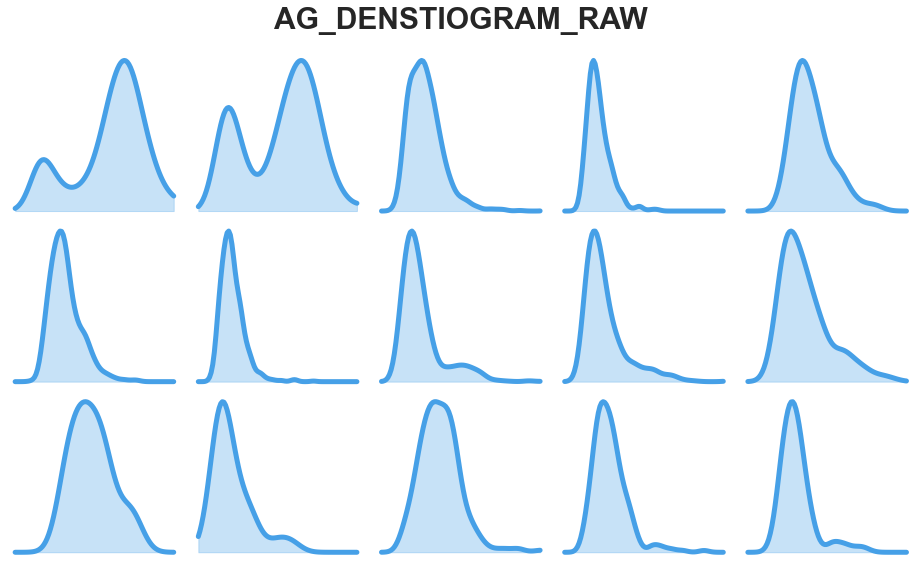

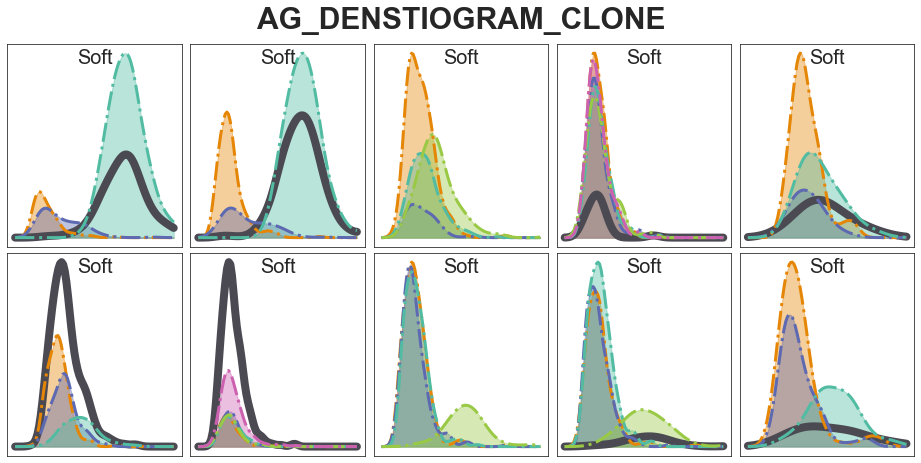

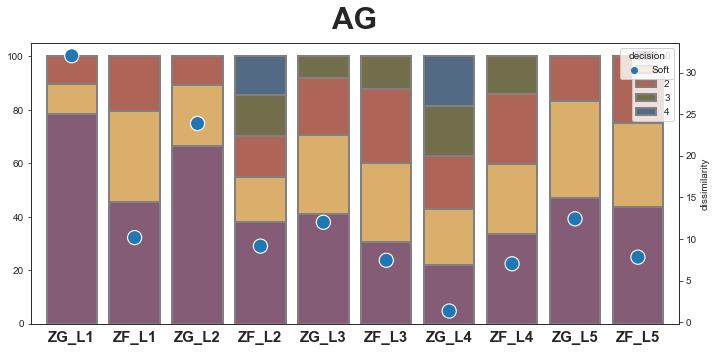

In [4]:
import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors

df_AG_count  = pd.DataFrame()
decision_dict = {}


# General_raw
fig_raw, ax_raw = plt.subplots(nrows = 3, ncols = 5, figsize = (14,8))
fig_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_raw.suptitle ( "AG_DENSTIOGRAM_RAW" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

# General_decomposition
fig_clone, ax_clone = plt.subplots(nrows = 2, ncols = 5, figsize = (14, 6.5))
fig_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_clone.suptitle ( "AG_DENSTIOGRAM_CLONE" , fontsize = 30, y = 0.98, fontweight = "semibold")


for col_index, location in enumerate( ["L1", "L2", "L3", "L4", "L5"] ) :
    # DIR_glo = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/glomerulosa_{}/0.input_containpos.txt".format(location)
    # DIR_fasc = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D_AG/fasciculata_{}/0.input_containpos.txt".format(location)
    DIR_glo = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/adrenal_gland_zona_glomerulosa/PD28690-{}".format(location)
    DIR_fasc = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/adrenal_gland_zona_fasciculata/PD28690-{}".format(location)

    glo_INPUT_TSV = DIR_glo + "/0.input_containpos.txt"
    fasc_INPUT_TSV = DIR_fasc + "/0.input_containpos.txt"
    reti_INPUT_TSV = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/3.woMosaic_ver2/PD28690/adrenal_gland_zona/reticularis_{}_input.txt".format(location)

    df_glo = pd.read_csv (glo_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_glo = calc_vaf (df_glo, "depthalt", location)
    df_fasc = pd.read_csv (fasc_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_fasc = calc_vaf (df_fasc, "depthalt", location)
    df_reti = pd.read_csv (reti_INPUT_TSV, sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_reti = calc_vaf (df_reti, "depthalt", location)

    df_glofasc = pd.merge ( df_glo,  df_fasc, left_on = "pos", right_on = "pos")
    
    drawfigure_raw ( ax_raw[0][col_index], df_glo, 0, col_index, "vaf", color = '#46A0E7' )
    drawfigure_raw ( ax_raw[1][col_index], df_fasc, 1, col_index, "vaf", color = '#46A0E7' )
    drawfigure_raw ( ax_raw[2][col_index], df_reti, 2, col_index, "vaf", color = '#46A0E7' )
    

    ####################################
    df_glo_membership = pd.read_csv ( DIR_glo + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])
    df_fasc_membership = pd.read_csv (DIR_fasc + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])

    df_glo = pd.concat ( [df_glo, df_glo_membership], axis = 1)
    df_fasc = pd.concat ( [df_fasc, df_fasc_membership], axis = 1)

    with open( DIR_glo + "/result/CLEMENT_decision.evidence.txt", "r") as file:
        decision_glo  = (file.readline().rstrip("\n").split("\t")[-1] ).split("_")[0]
    with open( DIR_fasc + "/result/CLEMENT_decision.evidence.txt", "r") as file:
        decision_fasc  = (file.readline().rstrip("\n").split("\t")[-1] ).split("_")[0]
    
    df_glo_posterior_allsample = np.zeros ( (df_glo.shape[0], len (set ( df_glo["clone"]) )  ), dtype = float )
    df_fasc_posterior_allsample = np.zeros ( (df_fasc.shape[0], len (set ( df_fasc["clone"]) )  ), dtype = float )
    if decision_glo in ["soft", "Soft"]:
        df_glo_posterior_allsample = np.array (pd.read_csv (DIR_glo + "/CLEMENT_soft_1st.posterior_allsample_normalize.txt", header = None, sep = "\t"))
    if decision_fasc in ["soft", "Soft"]:
        df_fasc_posterior_allsample = np.array (pd.read_csv (DIR_fasc + "/CLEMENT_soft_1st.posterior_allsample_normalize.txt", header = None, sep = "\t"))
    print (df_glo_posterior_allsample.shape, df_glo.shape )



    #  Common 그리기
    weight = df_glofasc.shape[0] / max ( pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[:, 0] )        # 대장 clone의 개수에 비해 common mutation의 개수?
    drawfigure_common (ax_clone[0][col_index], df_glofasc, 0, col_index, "vaf_x", weight)
    weight = df_glofasc.shape[0] / max ( pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[:, 0] )      # 대장 clone의 개수에 비해 common mutation의 개수?
    drawfigure_common (ax_clone[1][col_index], df_glofasc, 1, col_index, "vaf_y", weight)
    #print ( df_glofasc.shape[0] )

    # Clone 별로 그리기
    for clone_no in sorted ( set ( df_glo["clone"]) ) :
        weight = pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_glo.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_clone[0][col_index], df_glo, df_glo_posterior_allsample, 0, col_index, decision_glo, "vaf", clone_no, weight)
    for clone_no in sorted ( set ( df_fasc["clone"]) ) :
        weight = pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_fasc.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_clone[1][col_index], df_fasc, df_fasc_posterior_allsample, 1, col_index, decision_fasc, "vaf", clone_no, weight)

    # Hard, Soft 여부 적어놓기
    with open( DIR_glo + "/result/CLEMENT_decision.evidence.txt", 'r') as file:
        decision_glo = "Hard" if "hard" in file.readline().rstrip() else "Soft"
    with open( DIR_fasc + "/result/CLEMENT_decision.evidence.txt", 'r') as file:
        decision_fasc = "Hard" if "hard" in file.readline().rstrip() else "Soft"
    
    ax_clone[0][col_index].text (x = np.array (ax_clone[0][col_index].get_xlim()).mean(), y =  np.array (ax_clone[0][col_index].get_ylim())[1] * 0.9, ha = "center", s = "{}".format( decision_glo ), fontsize = 20, fontweight = "normal")
    ax_clone[1][col_index].text (x = np.array (ax_clone[1][col_index].get_xlim()).mean(), y =  np.array (ax_clone[1][col_index].get_ylim())[1] * 0.9, ha = "center", s = "{}".format( decision_fasc ), fontsize = 20, fontweight = "normal")

    decision_dict ["ZG_{}".format(location)] = decision_glo
    decision_dict ["ZF_{}".format(location)] = decision_fasc


    ##################### Stacked bar chart  (by mutation count) #####################
    temp = pd.read_csv ( DIR_glo + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
    temp.columns = ["ZG_{}".format(location)]
    df_AG_count = pd.concat ( [df_AG_count, temp], axis = 1).fillna(0).astype("int")
    temp = pd.read_csv ( DIR_fasc + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
    temp.columns = ["ZF_{}".format(location)]
    df_AG_count = pd.concat ( [df_AG_count, temp], axis = 1).fillna(0).astype("int")
    


colorlist = [i for i in Antique_10]
fig_AG_stackedbar, ax_AG_stackedbar = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
fig_AG_stackedbar.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.1, top = 0.88, left = 0.05, right = 0.95)
fig_AG_stackedbar.suptitle ( "AG" , fontsize = 30, y = 0.98, fontweight = "semibold")
kwargs = {}
kwargs ["ORDER"], kwargs["ROTATION"] = "Hard-Soft", 0
normalize_df_AG, df_order_AG = stackedbar_tissue ( fig_AG_stackedbar, ax_AG_stackedbar, df_AG_count, decision_dict, colorlist, **kwargs)


##################### dissimilarity  (by mutation count) #####################
dissimilarity_df = pd.DataFrame ( normalize_df_AG.apply(std_without_zeros, axis=1)  )
dissimilarity_df.columns = ["dissimilarity"]
dissimilarity_df = pd.merge ( dissimilarity_df, df_order_AG, left_index=True, right_index = True )    # Hard, Soft 여부 붙여주기
dissimilarity_df["SAMPLENAME"] = dissimilarity_df.index
dissimilarity_df["TISSUE"] = "AG"
dissimilarity_df = dissimilarity_df.reset_index(drop = True)

ax_AG_stackedbar_twin = ax_AG_stackedbar.twinx()
sns.scatterplot (dissimilarity_df, x = "SAMPLENAME", y = "dissimilarity", hue = "decision", s = 200, ax = ax_AG_stackedbar_twin )


fig_raw.savefig (OUTPUT_DIR + "/1-1.AG_densigoram_raw.pdf", dpi = 300)
fig_clone.savefig (OUTPUT_DIR + "/1-2.AG_densigoram_clone.pdf", dpi = 300)
fig_AG_stackedbar.savefig (OUTPUT_DIR + "/1-3.AG_stackedbar.pdf", dpi = 300)
fig_raw.show()
fig_clone.show()
fig_AG_stackedbar.show()


## Bronchus Epithelium

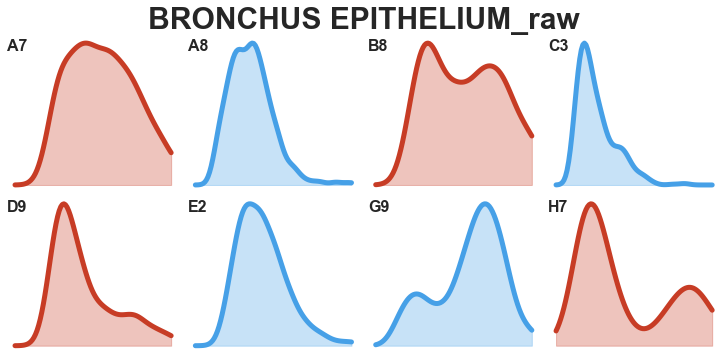

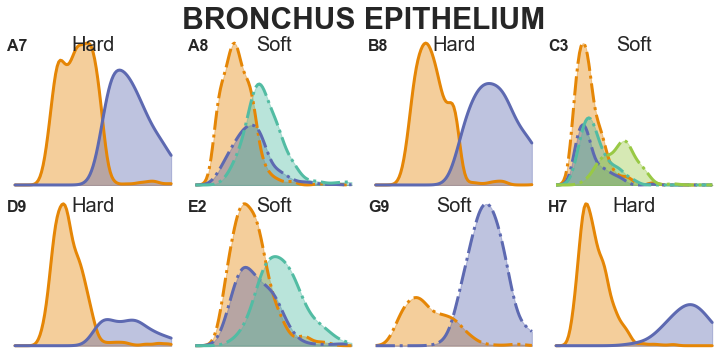

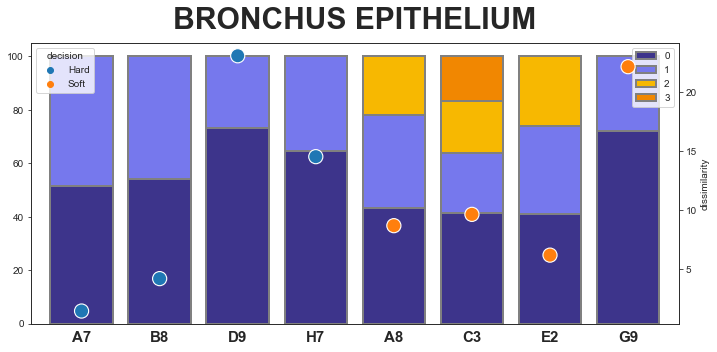

In [5]:
import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors


# General_clone
fig_bron_raw, ax_bron_raw = plt.subplots(nrows = 2, ncols = 4, figsize = (11,5))
fig_bron_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_bron_raw.suptitle ( "BRONCHUS EPITHELIUM_raw" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

# General_clone
fig_bron_clone, ax_bron_clone = plt.subplots(nrows = 2, ncols = 4, figsize = (11,5))
fig_bron_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.90, left = 0.05, right = 0.95)
fig_bron_clone.suptitle ( "BRONCHUS EPITHELIUM" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/bronchus_epithelium"
INPUT_DIR_LIST = sorted ( glob.glob ( DIR + "/*" ) )


df_bron_count  = pd.DataFrame()
decision_dict = {}


for INPUT_DIR_ind, INPUT_DIR in enumerate (INPUT_DIR_LIST):
    ax_row, ax_col = int(INPUT_DIR_ind / 4), INPUT_DIR_ind % 4
    SAMPLENAME = INPUT_DIR.split("-")[-1]
    #print (SAMPLENAME, ax_row, ax_col)

    #################################################
    df_bron = pd.read_csv (INPUT_DIR + "/0.input_containpos.txt", sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
    df_bron = calc_vaf (df_bron, "depthalt", SAMPLENAME)

    df_bron_membership = pd.read_csv ( INPUT_DIR + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])

    df_bron = pd.concat ( [df_bron, df_bron_membership], axis = 1)


    with open( INPUT_DIR + "/CLEMENT_decision.evidence.txt".format (location), 'r') as file:
        decision_bron = "Hard" if "hard" in file.readline().rstrip() else "Soft"

    
    # Raw 그리기
    #drawfigure_raw ( ax_bron_raw[ax_row][ax_col], df_bron, ax_row, ax_col, "vaf", color = '#46A0E7' )   
    if decision_bron == "Hard":
        drawfigure_raw ( ax_bron_raw[ax_row][ax_col], df_bron, ax_row, ax_col, "vaf", color = '#C73C25' )
        df_bron_posterior_allsample = np.zeros ( (df_bron.shape[0], len (set ( df_bron["clone"]) )  ), dtype = float )
    elif decision_bron == "Soft":
        drawfigure_raw ( ax_bron_raw[ax_row][ax_col], df_bron, ax_row, ax_col, "vaf", color = '#46A0E7' )
        df_bron_posterior_allsample = np.array (pd.read_csv (INPUT_DIR + "/CLEMENT_soft_1st.posterior_allsample_normalize.txt", header = None, sep = "\t"))

    # Clone 별로 그리기
    for clone_no in sorted ( set ( df_bron["clone"]) ) :
        weight = pd.DataFrame (df_bron.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_bron.groupby(["clone"]).count()).iloc[:, 0] )
        drawfigure_clone ( ax_bron_clone[ax_row][ax_col], df_bron, df_bron_posterior_allsample, ax_row, ax_col, decision_bron, "vaf", clone_no, weight)
    

    # Hard, Soft 여부 적어놓기
    ax_bron_clone[ax_row][ax_col].text (x = np.array (ax_bron_clone[ax_row][ax_col].get_xlim()).mean(), 
                                                    y =  np.array (ax_bron_clone[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                    ha = "center", s = "{}".format( decision_bron ), fontsize = 20, fontweight = "normal")
    decision_dict [SAMPLENAME] = decision_bron

    # Sample 이름 적기
    ax_bron_clone[ax_row][ax_col].text (x = np.array (ax_bron_clone[ax_row][ax_col].get_xlim()).min(), 
                                                    y = np.array (ax_bron_clone[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                    ha = "left", s = "{}".format( SAMPLENAME ), fontsize = 16, fontweight = "semibold")
    
    ax_bron_raw[ax_row][ax_col].text (x = np.array (ax_bron_raw[ax_row][ax_col].get_xlim()).min(), 
                                                    y = np.array (ax_bron_raw[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                    ha = "left", s = "{}".format( SAMPLENAME ), fontsize = 16, fontweight = "semibold")
    

    ##################### Stacked bar chart  (by mutation count) #####################
    temp = pd.read_csv ( INPUT_DIR + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
    temp.columns = [SAMPLENAME]
    df_bron_count = pd.concat ( [df_bron_count, temp], axis = 1).fillna(0).astype("int")



colorlist = [i for i in Antique_10]
colorlist = ["#D8E2DC","#FFE5D9","#FFCAD4","#F4ACB7","#9D8189"]
colorlist = ["#3D348B", "#7678ED", "#F7B801", "#F18701", "#F35B04"]
fig_bron_stackedbar, ax_bron_stackedbar = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
fig_bron_stackedbar.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.1, top = 0.88, left = 0.05, right = 0.95)
fig_bron_stackedbar.suptitle ( "BRONCHUS EPITHELIUM" , fontsize = 30, y = 0.98, fontweight = "semibold")
kwargs = {}
kwargs ["ORDER"], kwargs["ROTATION"] = "Hard-Soft", 0
normalize_df_bron, df_order_bron = stackedbar_tissue ( fig_bron_stackedbar, ax_bron_stackedbar, df_bron_count, decision_dict, colorlist, **kwargs)



##################### dissimilarity  (by mutation count) #####################
dissimilarity_df = pd.DataFrame ( normalize_df_bron.apply(std_without_zeros, axis=1)  )
dissimilarity_df.columns = ["dissimilarity"]
dissimilarity_df = pd.merge ( dissimilarity_df, df_order_bron, left_index=True, right_index = True )    # Hard, Soft 여부 붙여주기
dissimilarity_df["SAMPLENAME"] = dissimilarity_df.index    # SAMPLENAME column 생성
dissimilarity_df["TISSUE"] = "Bronchus_Epithelium"            # TISSUE column 생성
dissimilarity_df = dissimilarity_df.reset_index(drop = True)

ax_bron_stackedbar_twin = ax_bron_stackedbar.twinx()
sns.scatterplot (dissimilarity_df, x = "SAMPLENAME", y = "dissimilarity", hue = "decision", s = 200, ax = ax_bron_stackedbar_twin )

fig_bron_raw.savefig (OUTPUT_DIR + "/2-1.Bronchus_densigoram_raw.pdf", dpi = 300)
fig_bron_clone.savefig (OUTPUT_DIR + "/2-2.Bronchus_densigoram_clone.pdf", dpi = 300)
fig_bron_stackedbar.savefig (OUTPUT_DIR + "/2-3.Bronchus_stackedbar.pdf", dpi = 300)

## TOTAL

MEAN DEPTH 20 (<=20)   :  /data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/adrenal_gland_zona_reticularis/PD28690-L1/result/CLEMENT_decision.results.txt
MEAN DEPTH 19 (<=20)   :  /data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/liver_bile_duct/PD28690-A9/result/CLEMENT_decision.results.txt
MEAN DEPTH 20 (<=20)   :  /data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/liver_bile_duct/PD28690-C7/result/CLEMENT_decision.results.txt
MEAN DEPTH 20 (<=20)   :  /data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/small_bowel_crypt/PD28690-A9/result/CLEMENT_decision.results.txt
MEAN DEPTH 19 (<=20)   :  /data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/small_bowel_crypt/PD28690-H8/result/CLEMENT_decision.results.txt
MEAN DEPTH 20 (<=20)   :  /data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/small_bowel_crypt/PD42565-H1/result/CLEMENT_decision.results.txt
MEAN DEPTH 20 (<=20)   :  /data

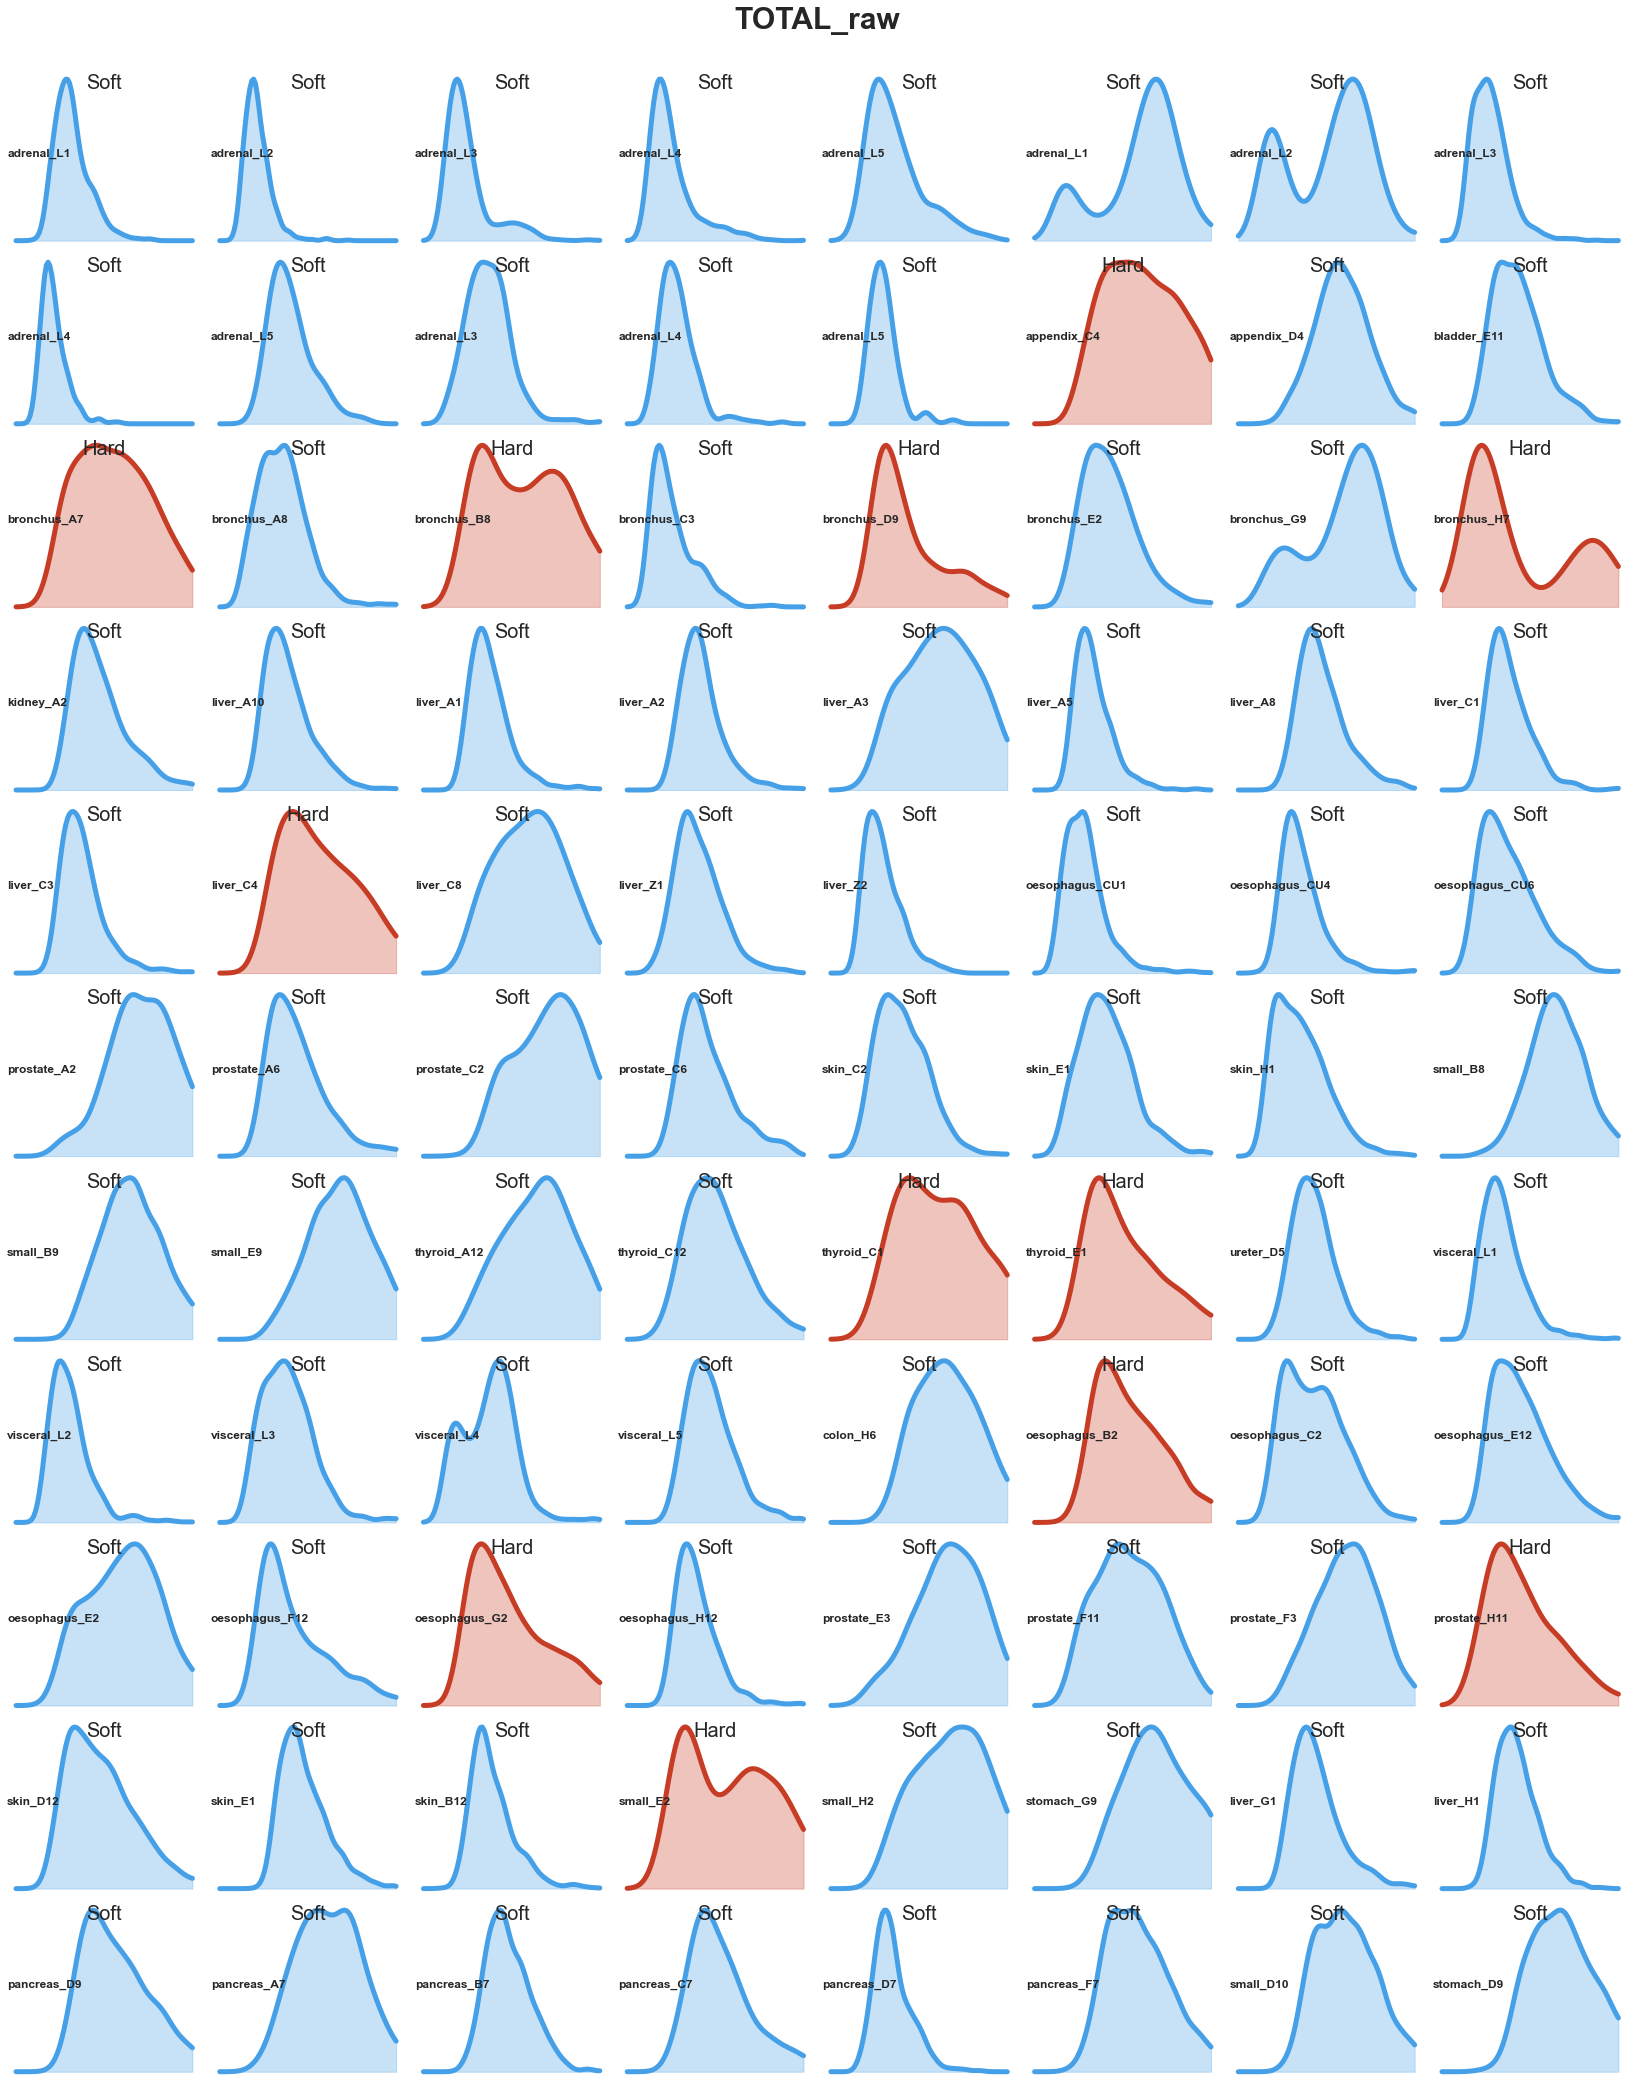

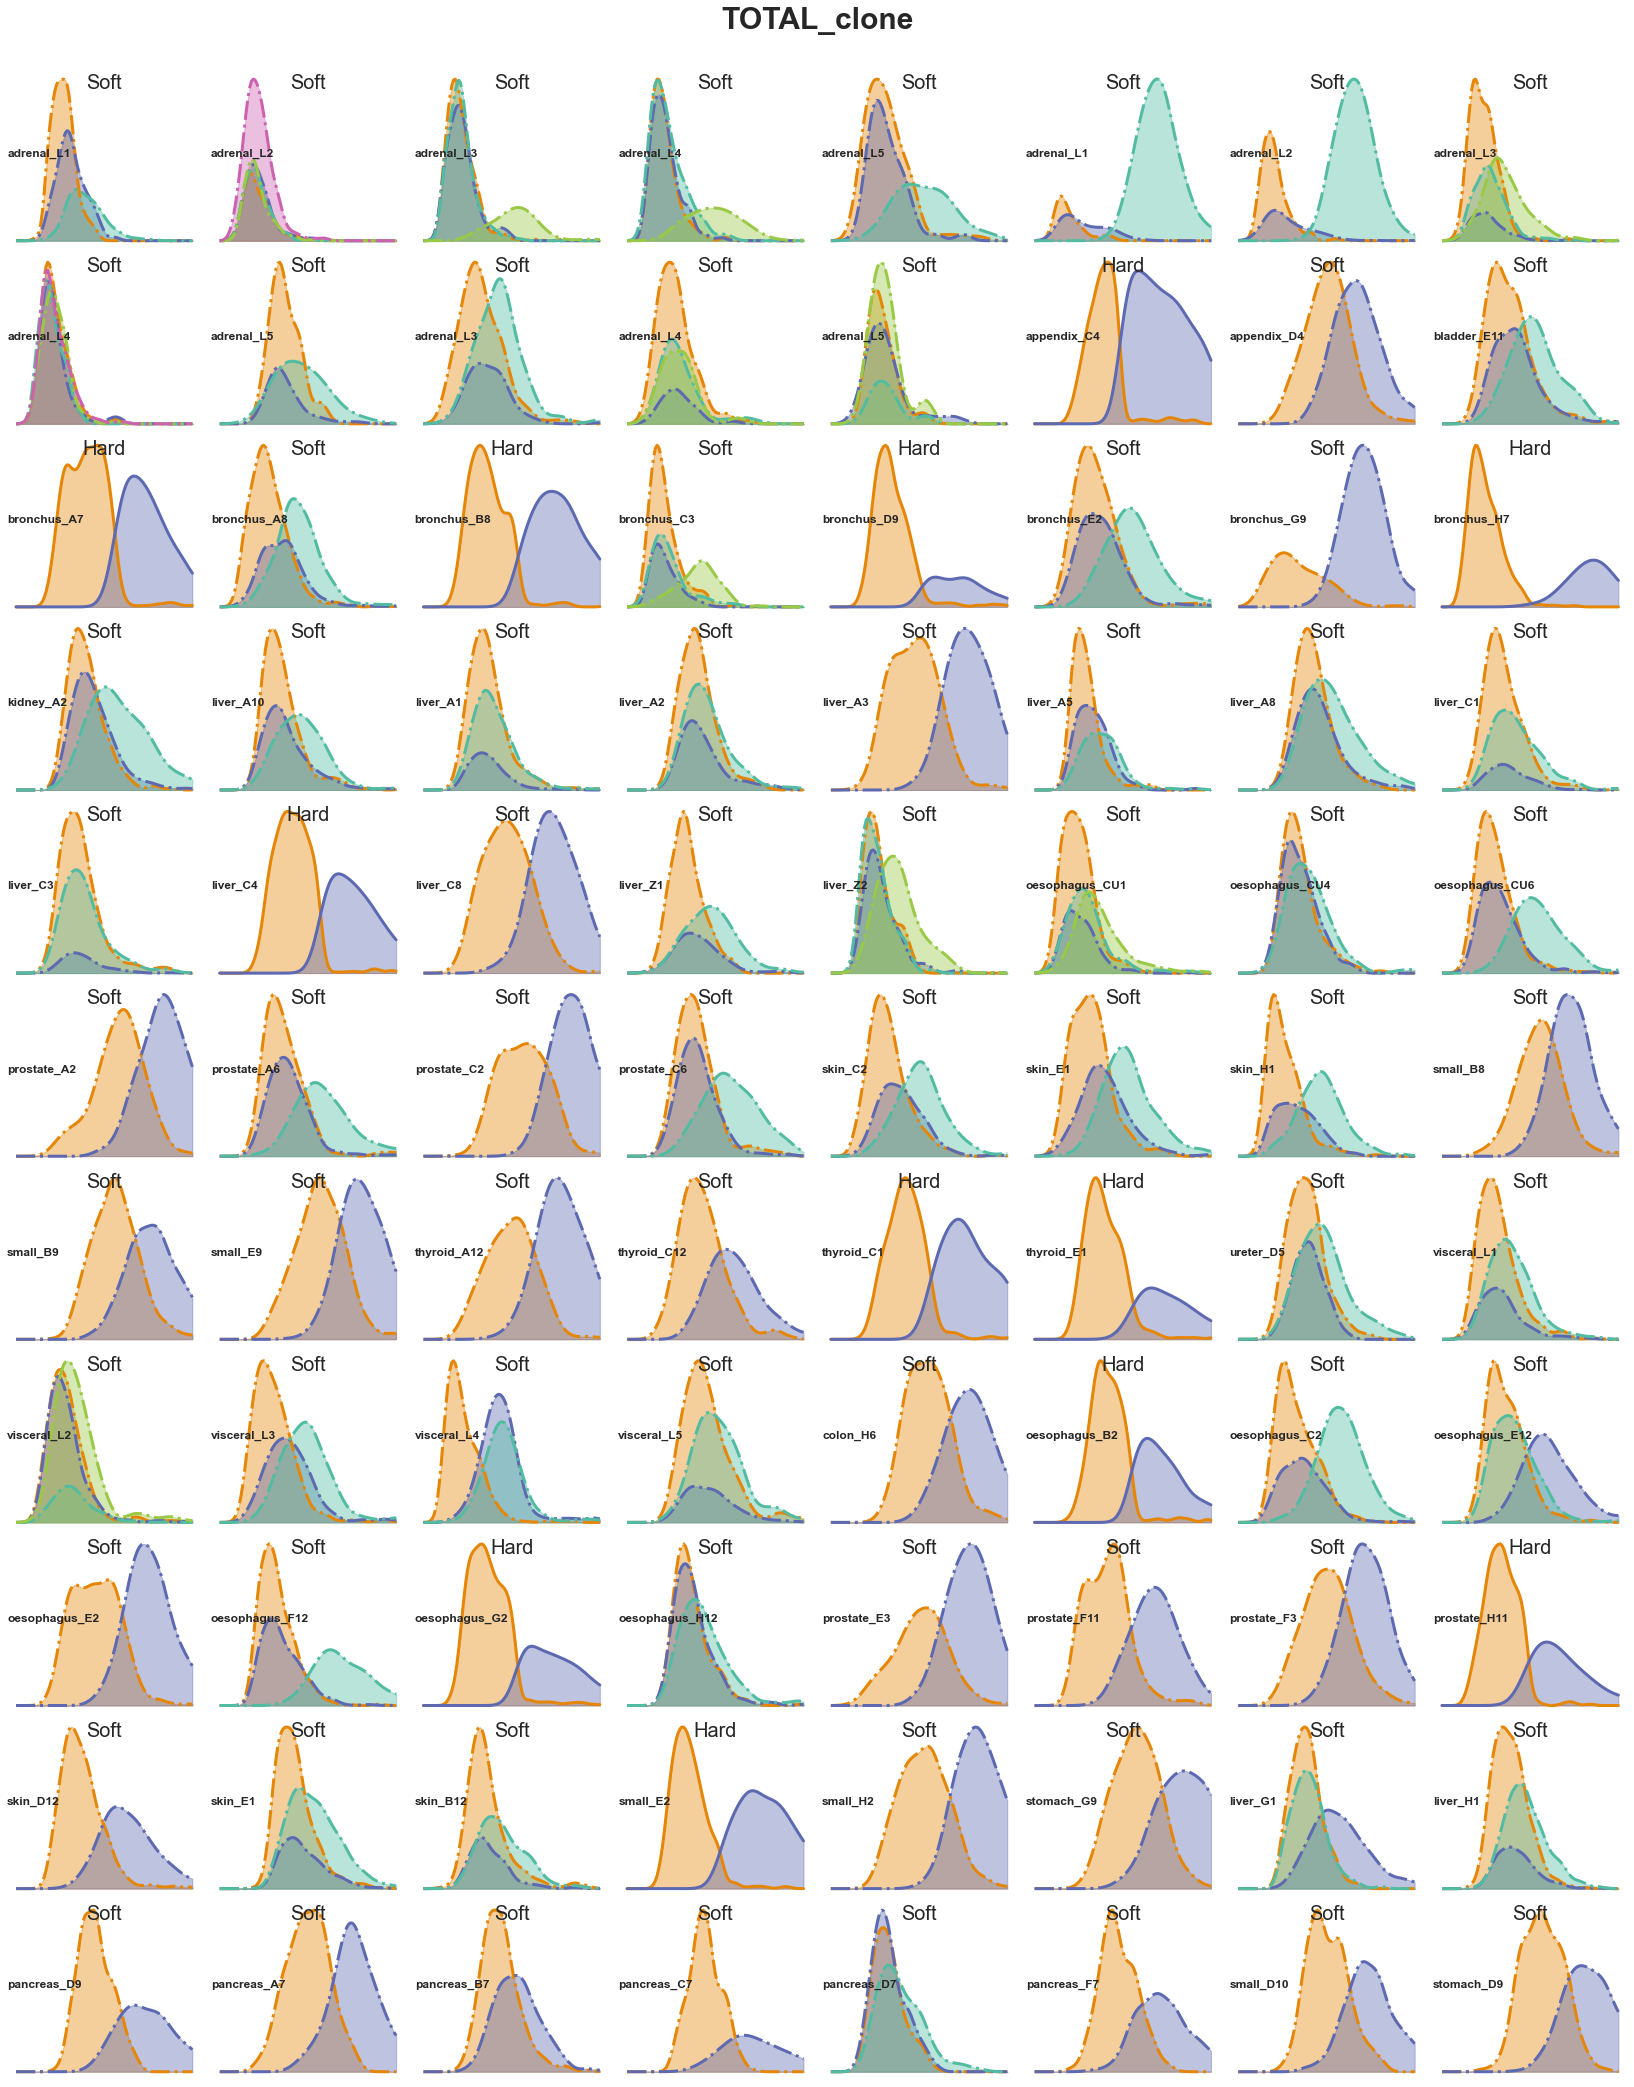

In [6]:
df_total_count  = pd.DataFrame()
decision_dict = {}

import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors


# General
fig_total_raw, ax_total_raw = plt.subplots(nrows = 11, ncols = 8, figsize = (25, 30))
fig_total_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.95, left = 0.05, right = 0.95)
fig_total_raw.suptitle ( "TOTAL_raw" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )

fig_total_clone, ax_total_clone = plt.subplots(nrows = 11, ncols = 8, figsize = (25, 30))
fig_total_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.95, left = 0.05, right = 0.95)
fig_total_clone.suptitle ( "TOTAL_clone" , fontsize = 30, y = 0.98, fontweight = "semibold")
sns.despine(  left=True, right=True, top=True, bottom=True )



DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/2.woMosaic_ver1"        # AG : 3.woMosaic_ver2
DONOR_LIST = [i.split("/")[-1] for i in sorted(glob.glob(DIR + "/*")) ]
n = 0
n_monoclonal = 0
n_hard = 0

for DONOR in DONOR_LIST:               # PD42566
    TISSUE_LIST = sorted( glob.glob (DIR + "/" + DONOR + "/*") ) 
    TISSUE_LIST = [i.split("/")[-1] for i in TISSUE_LIST]

    for TISSUE in TISSUE_LIST:               # colon_crypt, pancreas_islet
    #for TISSUE in [ "totalchus_epithelium", "liver_parenchyma" ]:

        SAMPLE_LIST = sorted ( glob.glob (DIR + "/" + DONOR + "/" + TISSUE + "/*") ) 
        SAMPLE_LIST = [i.split("/")[-1].split(".")[0] for i in SAMPLE_LIST]

        for SAMPLE in SAMPLE_LIST:       # PD42566b_lo00_A7.txt
            SAMPLENAME = SAMPLE.split("_")[0]
            INPUT_TSV = DIR + "/" + DONOR + "/" + TISSUE + "/" + SAMPLE + ".txt"

            COMBINED_OUTPUT_DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME

            if os.path.exists( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt" ) == False:   # 없다면 (CLEMENT error) 그냥 넘어가자
                continue
            try:
                result_df = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt", sep = "\t", header = None, index_col = 0)
            except:
                print ( "{} 뭔가 문제 있다".format ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt" ))
            if result_df.loc["NUM_CHILD"][1] == "1":    # monoclonal은 집에 가라
                n_monoclonal += 1
                continue

            with open( COMBINED_OUTPUT_DIR + "/0.input_mean_depth.txt", 'r') as file:
                MEAN_DEPTH = int ( file.readline().rstrip() )

            if MEAN_DEPTH <= 20:
                print ( "MEAN DEPTH {} (<=20)   :  {}".format (MEAN_DEPTH, COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt" ))
                continue

            #################################################
            ax_row, ax_col = int(n / 8), n % 8

            df_total = pd.read_csv ( COMBINED_OUTPUT_DIR + "/0.input_containpos.txt", sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
            df_total = calc_vaf (df_total, "depthalt", SAMPLENAME)

            df_total_membership = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])

            df_total = pd.concat ( [df_total, df_total_membership], axis = 1)

            

            with open( COMBINED_OUTPUT_DIR  + "/CLEMENT_decision.evidence.txt", 'r') as file:
                decision = "Hard" if "hard" in file.readline().rstrip() else "Soft"
                if decision == "Hard":
                    n_hard +=1
            decision_dict [TISSUE + "_" + SAMPLENAME] = decision


            # Raw 그리기
            if decision == "Hard":
                drawfigure_raw ( ax_total_raw[ax_row][ax_col], df_total, ax_row, ax_col, "vaf", color = '#C73C25' )
                df_total_posterior_allsample = np.zeros ( (df_total.shape[0], len (set ( df_total["clone"]) )  ), dtype = float )
            elif decision == "Soft":
                drawfigure_raw ( ax_total_raw[ax_row][ax_col], df_total, ax_row, ax_col, "vaf", color = '#46A0E7' )
                df_total_posterior_allsample = np.array (pd.read_csv (COMBINED_OUTPUT_DIR + "/CLEMENT_soft_1st.posterior_allsample_normalize.txt", header = None, sep = "\t"))

            # Clone 별로 그리기
            for clone_no in sorted ( set ( df_total["clone"]) ) :
                weight = pd.DataFrame (df_total.groupby(["clone"]).count()).iloc[clone_no, 0] / max ( pd.DataFrame (df_total.groupby(["clone"]).count()).iloc[:, 0] )
                drawfigure_clone ( ax_total_clone[ax_row][ax_col], df_total, df_total_posterior_allsample,  ax_row, ax_col, decision, "vaf", clone_no, weight)
                #drawfigure_clone ( ax_bron_clone[ax_row][ax_col], df_total, df_bron_posterior_allsample, ax_row, ax_col, decision_bron, "vaf", clone_no, weight)


            # Hard, Soft 여부 적어놓기
            ax_total_raw[ax_row][ax_col].text (x = np.array (ax_total_raw[ax_row][ax_col].get_xlim()).mean(), 
                                                                    y =  np.array (ax_total_raw[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                                    ha = "center", s = "{}".format( decision ), fontsize = 20, fontweight = "normal")
            ax_total_clone[ax_row][ax_col].text (x = np.array (ax_total_clone[ax_row][ax_col].get_xlim()).mean(), 
                                                                    y =  np.array (ax_total_clone[ax_row][ax_col].get_ylim())[1] * 0.9, 
                                                                    ha = "center", s = "{}".format( decision ), fontsize = 20, fontweight = "normal")

            # Sample 이름 적기
            ax_total_raw[ax_row][ax_col].text (x = np.array (ax_total_raw[ax_row][ax_col].get_xlim()).min(), 
                                                                        y = np.array (ax_total_raw[ax_row][ax_col].get_ylim())[1] * 0.5, 
                                                                        ha = "left", s = "{}_{}".format( TISSUE.split("_")[0], SAMPLENAME ), fontsize = 12, fontweight = "semibold")
            ax_total_clone[ax_row][ax_col].text (x = np.array (ax_total_clone[ax_row][ax_col].get_xlim()).min(), 
                                                                        y = np.array (ax_total_clone[ax_row][ax_col].get_ylim())[1] * 0.5, 
                                                                        ha = "left", s = "{}_{}".format( TISSUE.split("_")[0], SAMPLENAME ), fontsize = 12, fontweight = "semibold")


            ##################### Stacked bar chart  (by mutation count) #####################
            temp = pd.read_csv ( COMBINED_OUTPUT_DIR  + "/result/CLEMENT_decision.membership_count.txt", sep ="\t").T
            temp.columns = [TISSUE + "_" + SAMPLENAME]
            df_total_count = pd.concat ( [df_total_count, temp], axis = 1).fillna(0)


            #print (DONOR, TISSUE, SAMPLE, result_df.loc["NUM_CHILD"][1], decision, sep = "\t")
            n += 1

fig_total_raw.savefig (OUTPUT_DIR + "/3-1.Total_densigoram_raw.pdf", dpi = 300)
fig_total_clone.savefig (OUTPUT_DIR + "/3-2.Total_densigoram_clone.pdf", dpi = 300)





from collections import OrderedDict 
df_order = pd.DataFrame.from_dict ( OrderedDict (decision_dict), orient = "index" )
df_order.columns = ["decision"]


##################### dissimilarity  (by mutation count) #####################
normalized_df_total = df_total_count.div(df_total_count.sum(axis=0), axis=1).T * 100
normalized_df_total = normalized_df_total.apply(lambda row: pd.Series(sorted(row, reverse = True)), axis=1)

dissimilarity_df = pd.DataFrame ( normalized_df_total.apply(std_without_zeros, axis=1)  )  # dissimilarity score 계산
dissimilarity_df.columns = ["dissimilarity"]
dissimilarity_df["NUM_MUTATION"] = pd.Series( np.sum ( df_total_count, axis = 0 ).astype(int) )
dissimilarity_df = pd.concat ( [dissimilarity_df, df_order], axis = 1)          # Hard, Soft 여부 붙여주기
dissimilarity_df["SAMPLENAME"] = dissimilarity_df.index                       # SAMPLENAME column 생성
dissimilarity_df["TISSUE"] = dissimilarity_df["SAMPLENAME"].str.rsplit("_", n = 1).str[0]  # TISSUE column 생성
dissimilarity_df = dissimilarity_df.reset_index(drop = True)
dissimilarity_df = dissimilarity_df.sort_values (by = "dissimilarity", ascending = False, axis = 0)  # score에 따라 sort
dissimilarity_df = dissimilarity_df.reset_index(drop = True)

normalized_df_total = normalized_df_total.loc [ list( dissimilarity_df["SAMPLENAME"]), : ]  # score에 따라 sort




In [7]:
print ("n(monoclonal)\t{}\nn(hard)\t{}\nn(soft)\t{}\nn(total)\t{}".format (n_monoclonal, n_hard, n - n_hard, n))

n(monoclonal)	115
n(hard)	12
n(soft)	76
n(total)	88


### Bootstrap을 통해 std의 분포를 구하기

[[29. 36. 35.]] 1277
[[37. 29. 34.]] 1496
[[45. 55.]] 1134
[[68. 32.]] 1258
[[31. 43. 27.]] 698
[[55. 45.]] 3666




mean = 5.55	std = 3.63	95% = 0~12.68


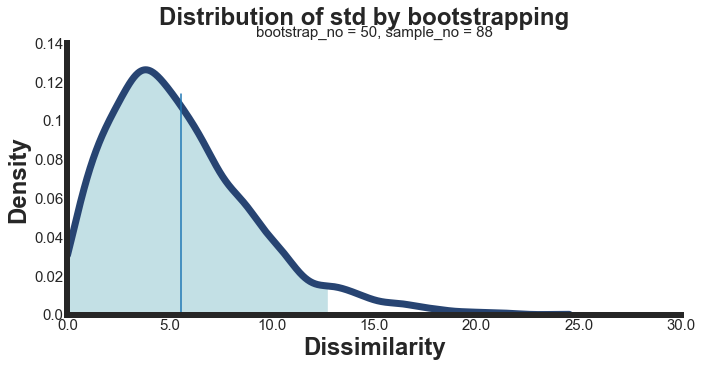

In [8]:
import scipy.stats

def random_choice (NUM_CLONE, MUTATION_COUNT):
    li = np.random.choice( list( range (0, NUM_CLONE)), size = MUTATION_COUNT, replace=True)
    counts =  np.unique (li, return_counts = True )[1] 
    return counts
def dirichlet_choice (NUM_CLONE, MUTATION_COUNT):
    li_2 = [ 20 ] * NUM_CLONE
    counts = (np.random.dirichlet ( li_2 , 1 ) * MUTATION_COUNT).astype (int)
    return counts    # li_2가 0인 것은 뺴고 수행

BOOTSTRAP_NO = 50
std_list = []

for BOOTSTRAP_I in range (BOOTSTRAP_NO):
    for i in range ( normalized_df_total.shape[0] ):
        NUM_CLONE = np.count_nonzero ( normalized_df_total.iloc[i] != 0)
        MUTATION_COUNT =  dissimilarity_df.iloc[i]["NUM_MUTATION"]  #400
        #print ("{}\tNUM_MUTATION = {}\tNUM_CLONE = {}".format ( normalized_df_total.index [i], dissimilarity_df.iloc[i]["NUM_MUTATION"], NUM_CLONE  ) ) 

        counts = random_choice (NUM_CLONE, MUTATION_COUNT)
        counts = dirichlet_choice (NUM_CLONE, MUTATION_COUNT)

        percentage = counts / MUTATION_COUNT * 100
        if (BOOTSTRAP_I == 1) & (i <= 5) :
            print ( np.round(percentage) , MUTATION_COUNT )
        std_list.append ( np.std(percentage) )


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (11,5))

x = np.arange (0, np.max(std_list), np.max(std_list) / 1000)
kde = scipy.stats.gaussian_kde( std_list )
y = kde(x)
ax.plot (x, y, linewidth = 7, c = "#274472")
ax.axvline (x = np.mean(std_list), ymin = 0, ymax = kde ( np.round ( np.mean(std_list) , 2) )[0] / ax.get_ylim()[1] )


#print ( "mean = {}\tstd = {}\t95%CI = {}~{}".format ( round(np.mean(std_list), 2), round (np.std (std_list), 2) , round ( np.mean(std_list) - 1.96 * np.std(std_list), 2),  round ( np.mean(std_list) + 1.96 * np.std(std_list), 2) ) )
#lower_limit, upper_limit = max ( 0, round ( np.mean(std_list) - 1.96 * np.std(std_list), 2)),  round ( np.mean(std_list) + 1.96 * np.std(std_list), 2) 

lower_limit, upper_limit =0,  round ( sorted(std_list)  [ (int (len(std_list) * 0.95))], 2 ) 
print ( "\n\nmean = {}\tstd = {}\t95% = {}~{}".format ( round(np.mean(std_list), 2), round (np.std (std_list), 2) , lower_limit,  upper_limit ) )

condition = (x >= lower_limit) & (x <= upper_limit)
ax.fill_between(x[condition], y[condition], color = "#C3E0E5" )


sns.despine ( top = True, right = True, ax = ax)
for axis in ['left','bottom']:
    ax.spines[axis].set_linewidth( 6 )

fig.suptitle ( "Distribution of std by bootstrapping", fontsize = 24, fontweight = "semibold"  )
ax.set_title ( "bootstrap_no = {}, sample_no = {}".format ( BOOTSTRAP_NO, normalized_df_total.shape[0] ), fontsize = 15 )
ax.set_xlabel( "Dissimilarity", fontsize = 24, fontweight = "semibold"  )
ax.set_ylabel( "Density", fontsize = 24, fontweight = "semibold"  )
# ax.xaxis.set_label_coords( 0.5, -0.12)  # xlabel을 이동 (- 아래쪽)
# ax.yaxis.set_label_coords( -0.1, 0.5)  # ylabel을 이동 (- 왼쪽)
# ax.set_xticks ( np.arange (0, 1, 0.1) ) 
# ax.set_yticks ( np.arange (0, 1, 0.1) ) 
ax.set_xlim ( [0, ax.get_xlim()[1]])
ax.set_ylim ( [0, ax.get_ylim()[1]])
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels ( np.round (ax.get_xticks(), 0).astype(float) , fontsize = 15, fontweight = "normal" ) 
ax.set_yticklabels ( np. round (ax.get_yticks(), 2), fontsize = 15, fontweight = "normal" ) 

ax.tick_params(axis='x', direction='out', length = 3, pad = 1)
ax.tick_params(axis='y', direction='out', length = 3, pad = 1)

fig_total_raw.savefig (OUTPUT_DIR + "/3-4.Bootstrap.pdf", dpi = 300)

### Stacked bar chart

<ipython-input-2-a395ddd136e3>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels ( ax.get_yticklabels(), fontsize = 14, fontweight = "normal")
<ipython-input-11-3d257cf9cf30>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_total_stackedbar_twin.set_yticklabels ( ax_total_stackedbar_twin.get_yticklabels(), fontsize = 14, fontweight = "normal")


upper_limit = 12.68


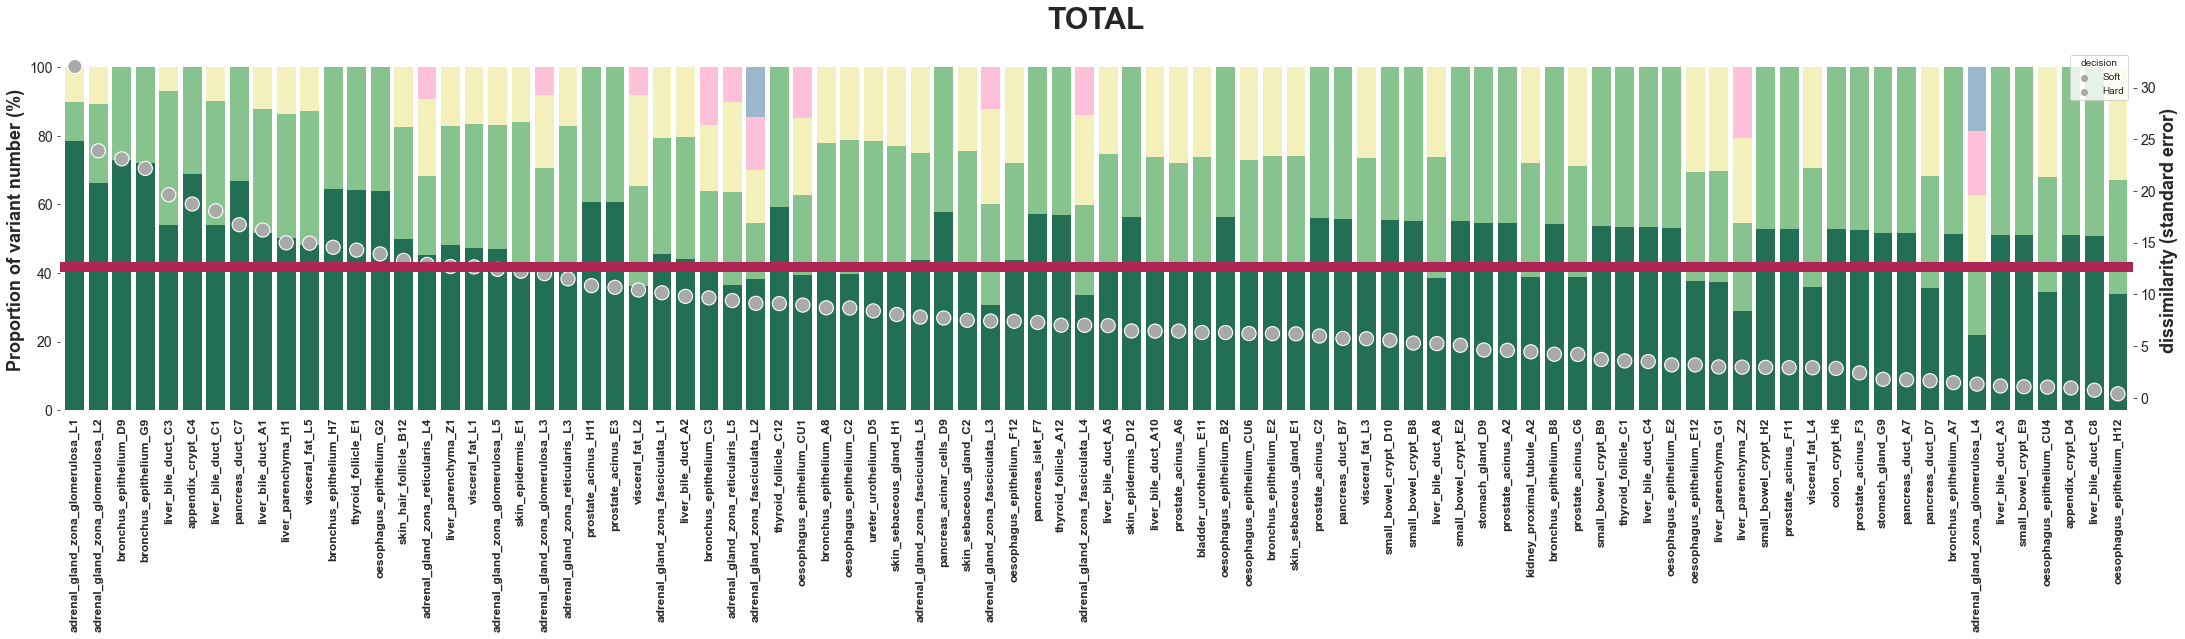

In [11]:
colorlist = [i for i in Antique_10]
colorlist = ["#3D348B", "#7678ED", "#F7B801", "#F18701", "#F35B04"]
colorlist = ["#226f54",  "#87c38f", "#f4f0bb", "#ffc0d9", "#9bb8cd" ]

fig_total_stackedbar, ax_total_stackedbar = plt.subplots(nrows = 1, ncols = 1, figsize = (32,10))
fig_total_stackedbar.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.42, top = 0.92, left = 0.05, right = 0.95)
fig_total_stackedbar.suptitle ( "TOTAL" , fontsize = 30, y = 0.98, fontweight = "semibold")
kwargs = {}
kwargs["ROTATION"] = 90
stackedbar_by_score (  fig_total_stackedbar, ax_total_stackedbar, normalized_df_total, colorlist, **kwargs)

ax_total_stackedbar_twin = ax_total_stackedbar.twinx()
sns.scatterplot (dissimilarity_df, x = "SAMPLENAME", y = "dissimilarity", hue = "decision", s = 200, palette = {"Hard" : '#a9a9a9', "Soft" : '#a9a9a9' }, ax = ax_total_stackedbar_twin )
ax_total_stackedbar_twin.axhline(y = upper_limit, color = '#af2655', linestyle='-', linewidth = 10,  label = 'Threshold (95%)')
ax_total_stackedbar_twin.set_ylabel ("dissimilarity (standard error)", fontsize = 18, fontweight = "semibold")
ax_total_stackedbar_twin.set_yticklabels ( ax_total_stackedbar_twin.get_yticklabels(), fontsize = 14, fontweight = "normal")
sns.despine(  left=True, right=True, top=True, bottom=True, ax = ax_total_stackedbar )
sns.despine(  left=True, right=True, top=True, bottom=True, ax = ax_total_stackedbar_twin )

fig_total_stackedbar.savefig (OUTPUT_DIR + "/3-3.Total_stackedbar.pdf", dpi = 300)
print ("upper_limit = {}".format (upper_limit))

In [10]:
li = [i for i in np.array ( df_total_count ).flatten() if i != 0]
print ( sorted (li) )
print ( "Clone별 mutation 개수의 평균 : {}\t표준편차 : {}\t최소 : {}\t최대 : {}".format (  np.mean ( li ), np.std (  li  ), np.min (li) , np.max(li) ) )

[9.0, 23.0, 24.0, 27.0, 32.0, 37.0, 46.0, 49.0, 58.0, 67.0, 71.0, 75.0, 75.0, 79.0, 83.0, 88.0, 89.0, 94.0, 95.0, 96.0, 97.0, 97.0, 97.0, 100.0, 109.0, 110.0, 110.0, 111.0, 111.0, 113.0, 114.0, 114.0, 117.0, 119.0, 120.0, 120.0, 120.0, 127.0, 127.0, 127.0, 128.0, 129.0, 130.0, 130.0, 130.0, 134.0, 134.0, 136.0, 136.0, 138.0, 142.0, 142.0, 143.0, 143.0, 145.0, 145.0, 145.0, 151.0, 152.0, 153.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 165.0, 167.0, 168.0, 169.0, 176.0, 180.0, 182.0, 192.0, 193.0, 194.0, 194.0, 195.0, 200.0, 200.0, 201.0, 202.0, 207.0, 211.0, 213.0, 216.0, 219.0, 223.0, 223.0, 223.0, 224.0, 227.0, 229.0, 232.0, 235.0, 237.0, 241.0, 241.0, 241.0, 243.0, 245.0, 248.0, 251.0, 251.0, 254.0, 254.0, 255.0, 255.0, 261.0, 261.0, 266.0, 266.0, 266.0, 266.0, 268.0, 268.0, 271.0, 272.0, 273.0, 274.0, 275.0, 285.0, 285.0, 287.0, 293.0, 294.0, 295.0, 298.0, 299.0, 304.0, 305.0, 305.0, 307.0, 312.0, 312.0, 314.0, 315.0, 317.0, 320.0, 321.0, 325.0, 329.0, 342.0, 349.0, 3

### colon_crypt (PD40745-lo007)은 과연 정당한가

In [30]:
import pandas as pd
import numpy as np

input_containpos = pd.read_csv ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/colon_crypt/PD40745-lo0007/0.input_containpos.txt", sep = "\t", header = None)
CLEMENT_membership = np.array ( pd.read_csv("/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/colon_crypt/PD40745-lo0007/CLEMENT_decision.membership.txt", sep = "\t", header = None).iloc[:][0] )

depth_list = []
for k in range ( input_containpos.shape[0] ):
    depth_list.append(  int (input_containpos.iloc[k][2].split(",")[0] ) )

input_containpos ["depth"] = depth_list

for j in set ( list(CLEMENT_membership) ): 
    j_ind = np.where (CLEMENT_membership == j ) [0]
    print ( np.mean( [depth_list[k] for k in j_ind])  )
    #print (len(j_ind))

37.94764397905759
36.081344902386114
